Adithya Palle \
March 30, 2025 \
Final Project

Jupyter Notebook for running CNN and optical flow models on the stream of data and determining classfication accuracy.

In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
from data_extraction import get_video_data, FIRE_VIDEOS_DATA_PATH
import os

In [3]:
val_fire_videos, val_no_fire_videos = get_video_data(os.path.join(FIRE_VIDEOS_DATA_PATH, "validation"))
test_fire_videos, test_no_fire_videos = get_video_data(os.path.join(FIRE_VIDEOS_DATA_PATH, "test"))


In [ ]:
import random
from video_model import VideoModel, VideoModelFromImageModel
from cnn import CNNFireDetector
from train_cnn import InferenceModel, TrainingModel, TRANSFORM
from optical_flow import FarnebackOpticalFlowModel
import torch
# Load models



MODEL_NAME = "final_exp"
device = torch.device("cpu")#torch.device("cuda" if torch.cuda.is_available() else "cpu")

my_image_model : VideoModel = VideoModelFromImageModel(CNNFireDetector.load_from_file(f"data/{MODEL_NAME}.pth", InferenceModel(TrainingModel()), device =device, transform = TRANSFORM ))
optical_flow_model : VideoModel = FarnebackOpticalFlowModel()

# model to run tests on
CHOSEN_MODEL = optical_flow_model


Number of parameters in the model: 1829897


In [ ]:
from prediction import get_predictions_on_videos, get_false_positive_rate, get_recall, get_accuracy
val_fire_predictions, _ , _ = get_predictions_on_videos(CHOSEN_MODEL, val_fire_videos)
val_no_fire_predictions, _ , _ = get_predictions_on_videos(CHOSEN_MODEL, val_no_fire_videos)






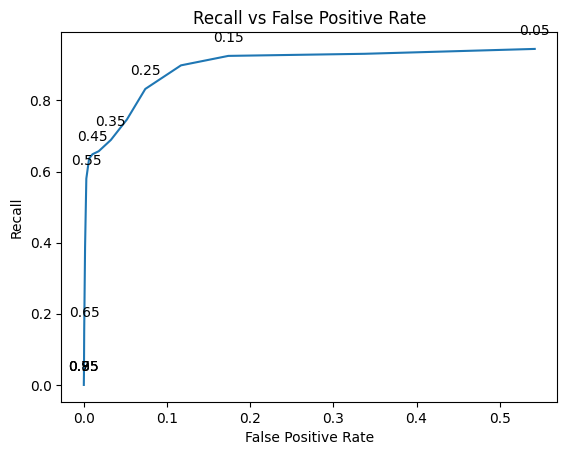

In [6]:
# use recall and FPR curve to determine best threshold for binarizing predictions
recalls = []
fprs = []
thresholds = [n/100 for n in range(5, 100, 5)] # threshold above which a prediction probabiltiy is considered fire
for threshold in thresholds:
    recall = get_recall(val_fire_predictions, threshold)
    false_positive_rate = get_false_positive_rate(val_no_fire_predictions, threshold)
    recalls.append(recall)
    fprs.append(false_positive_rate)


# plot recall vs false positive rate
import matplotlib.pyplot as plt
plt.plot(fprs, recalls)

# add point lables with threshold
for i in range(0, len(thresholds) , 2):
    txt = thresholds[i]
    plt.annotate(txt, (fprs[i], recalls[i]), textcoords="offset points", xytext=(0,10), ha='center')

plt.xlabel('False Positive Rate')
plt.ylabel('Recall')
plt.title('Recall vs False Positive Rate')
plt.show()

In [3]:
BEST_THRESHOLD = 0.15



In [ ]:

# get results on test videos
test_fire_predictions, total_time_ms_fire, total_fire_frames = get_predictions_on_videos(CHOSEN_MODEL, test_fire_videos)
test_no_fire_predictions, total_time_ms_nofire, total_nofire_frames = get_predictions_on_videos(CHOSEN_MODEL, test_no_fire_videos)
test_recall = get_recall(test_fire_predictions, BEST_THRESHOLD)
test_fpr = get_false_positive_rate(test_no_fire_predictions, BEST_THRESHOLD)
test_accuracy = get_accuracy(test_fire_predictions, test_no_fire_predictions, BEST_THRESHOLD) # TODO: fix
print("Test Accuracy: ", test_accuracy)
print("Test Recall: ", test_recall)
print("Test False Positive Rate: ", test_fpr)

total_time_ms = total_time_ms_fire + total_time_ms_nofire
total_frames = total_fire_frames + total_nofire_frames
avg_time_per_frame = total_time_ms / total_frames
print("Average time per frame (ms): ", avg_time_per_frame, " on device: " , device)


In [8]:
print(total_frames)

10366


In [9]:
del test_fire_videos
del test_no_fire_videos
del val_fire_videos
del val_no_fire_videos
# gpu cleanup

if torch.cuda.is_available(): 
    torch.cuda.empty_cache()  # Frees GPU memory from deleted tensors

In [5]:
import os
import cv2
import numpy as np
from data_extraction import load_frames_from_video
def save_video(frames, predictions, filename, threshold=0.5, fps=30):
    _ , h, w = np.array(frames[0]).shape
    out_path = os.path.join("data", filename)
    fourcc = cv2.VideoWriter_fourcc(*"avc1")  # use 'avc1' or 'XVID' if mp4v fails
    writer = cv2.VideoWriter()
    succes  = writer.open(out_path, fourcc, fps, (w, h))
    if not succes:
        raise Exception(f"Could not open video writer for {out_path}")
    for i, frame in enumerate(frames):
        # frame is in (C,H,W) format
        frame = frame.permute(1, 2, 0).numpy()  # convert (C, H, W) -> (H, W, C)
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)

def predict_on_video(model: VideoModel, video_path : str, save_name : str):
    if not os.path.isfile(video_path):
        raise ValueError("Invalid video_path")
    frames = load_frames_from_video(video_path)
    predictions = model.predict_on_full_video(frames)
    save_video(frames, predictions, save_name)
    

def save_video(frames, predictions, filename, threshold=BEST_THRESHOLD, fps=30):
    _ , h, w = np.array(frames[0]).shape
    out_path = os.path.join("data", filename)
    fourcc = cv2.VideoWriter_fourcc(*"mp4v")  # use 'avc1' or 'XVID' if mp4v fails
    writer = cv2.VideoWriter()
    succes  = writer.open(out_path, fourcc, fps, (w, h))
    if not succes:
        raise Exception(f"Could not open video writer for {out_path}")
    for i, frame in enumerate(frames):
        # frame is in (C,H,W) format
        frame = frame.permute(1, 2, 0).numpy()  # convert (C, H, W) -> (H, W, C)
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)

        text = "Fire" if predictions[i] >= threshold else "No Fire"
        color = (0, 0, 255) if text == "Fire" else (0, 255, 0)
        cv2.putText(frame, text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2)
        writer.write(frame)

    writer.release()
    print(f"Saved: {out_path}")

# Predict on the fire starting video and save result
predict_on_video(CHOSEN_MODEL, "data/efan_fire.mp4", "efan_pred.mp4")

#predict on video of fire and save 
predict_on_video(CHOSEN_MODEL, "data/fire_videos/test/pos/posVideo1.868.avi", "fire_vid_pred.mp4")
# predict on video of no fire and save
predict_on_video(CHOSEN_MODEL, "data/fire_videos/test/neg/negsVideo1.858.avi", "nofire_vid_pred.mp4")


/var/folders/1b/hwf75tz14fsffs3nqgyylfy80000gn/T/ipykernel_17284/4166291420.py:27: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  _ , h, w = np.array(frames[0]).shape


Saved: data/efan_pred.mp4
Saved: data/fire_vid_pred.mp4
Saved: data/nofire_vid_pred.mp4


In [ ]:
# gpu cleanup

if torch.cuda.is_available(): 
    torch.cuda.empty_cache()  # Frees GPU memory from deleted tensors